In [2]:
pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.1 MB/s eta 0:00:00


In [3]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import resampy

from tqdm import tqdm
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [16,4] # set figure size#


In [4]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip -O audiofiles.zip

--2025-05-04 23:00:46--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-05-04 23:00:47--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-05-04 23:00:47--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘audiofiles.zip’

audiofiles.zip          

In [5]:
import zipfile


local_zip = '/content/audiofiles.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/audiofiles')
zip_ref.close()


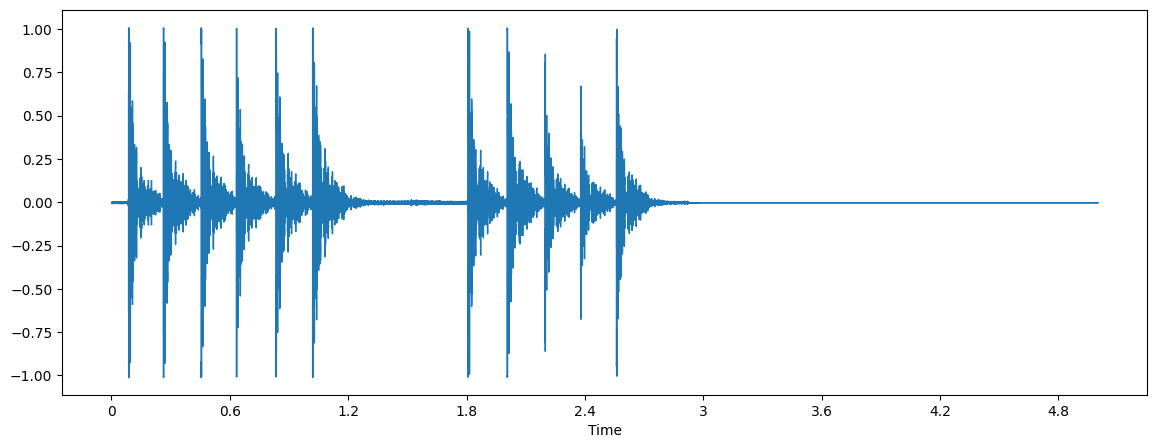

In [6]:
## loading audio file

#au1= r'D:\Documents_D\ESC-50-master\ESC-50-master\audio\1-7974-B-49.wav'
au1= r'/content/audiofiles/ESC-50-master/audio/1-101336-A-30.wav'


plt.figure(figsize=(14,5))
data, sample_rate=librosa.load(au1)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(au1)

In [8]:
data ## librosa also normalize the audio amplitude for each sample
c=(data.size)/60 ## 60sec is audio length
print(c, sample_rate) # sample rate

1837.5 22050


## Feature Extration

In [9]:
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfcc.shape)

(40, 216)


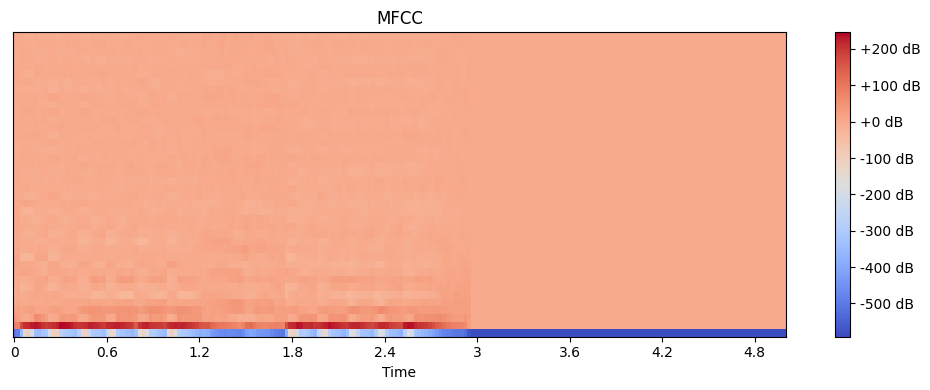

In [10]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [11]:

#metadata=pd.read_csv('D:\Documents_D\ESC-50-master\ESC-50-master\meta\esc50.csv')
metadata=pd.read_csv('/content/audiofiles/ESC-50-master/meta/esc50.csv')

metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [13]:
def features_extractor(file):
    au, sample_rate = librosa.load(file,res_type='kaiser_fast')
    mfcc_features=librosa.feature.mfcc(y=au,sr=sample_rate,n_mfcc=40)
    mfcc_scaled_features=np.mean(mfcc_features.T, axis=0)

    return mfcc_scaled_features

In [15]:
### Now we iterate through every audio file and extract MFCC using metadata csv file with

## main path of the audio files

#audio_dataset_path = r'D:\Documents_D\ESC-50-master\ESC-50-master\audio'
audio_dataset_path = r'/content/audiofiles/ESC-50-master/audio'



extracted_features=[] ## store the features and the labels

for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(audio_dataset_path, str(row["filename"])) ## very specific to the audio files path
    final_class_labels=row["category"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])



2000it [03:04, 10.86it/s]


In [16]:
## creating the list into dataframe

extracted_features_df=pd.DataFrame(extracted_features,columns=['features','labels'])
extracted_features_df.head()

,features,labels
0,"[-601.2905, 5.188324, -8.995635, -3.7940917, -...",dog
1,"[-199.9886, 11.223685, -67.78312, 12.683219, -...",chirping_birds
2,"[8.070245, 68.47494, -20.432165, 26.459606, -2...",vacuum_cleaner
3,"[9.428114, 66.635605, -18.865864, 25.20236, -2...",vacuum_cleaner
4,"[-427.5323, 131.2091, 32.553005, 41.130276, -8...",thunderstorm


In [17]:
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['labels'].tolist())
y

array(['dog', 'chirping_birds', 'vacuum_cleaner', ..., 'footsteps',
       'sheep', 'dog'], dtype='<U16')

In [19]:
### Label Encoding
y1=np.array(pd.get_dummies(y)).astype(int)

y1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y1,test_size=0.2,random_state=0)

In [21]:
y_train.shape

(1600, 50)

## Model training using tensorflow


In [22]:
import tensorflow as tf
print(tf.__version__)


from sklearn import metrics

2.18.0


In [23]:
## num of classes
num_labels=y1.shape[1]

print(y1[1])
print("Classes", y1.shape[1])
print("Input features", X_train.shape[1])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Classes 50
Input features 40


In [24]:
model = tf.keras.models.Sequential([


    tf.keras.layers.Dense(100, activation='relu', input_shape=(40,)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(200, activation='relu' ),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(200, activation='relu' ),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(50, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        10,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,550 (291.21 KB)

 Trainable params: 74,550 (291.21 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=r'D:\CS\Machine Learning\Audio-Signal-Processing-using-ML\audio_classification.keras',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/100
37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0225 - loss: 63.2739
Epoch 1: val_loss improved from inf to 4.35524, saving model to D:\CS\Machine Learning\Audio-Signal-Processing-using-ML\audio_classification.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0231 - loss: 57.7924 - val_accuracy: 0.0275 - val_loss: 4.3552
Epoch 2/100
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0230 - loss: 15.9181
Epoch 2: val_loss improved from 4.35524 to 3.91795, saving model to D:\CS\Machine Learning\Audio-Signal-Processing-using-ML\audio_classification.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0229 - loss: 15.7756 - val_accuracy: 0.0200 - val_loss: 3.9179
Epoch 3/100
26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0170 - loss: 8.9634  
Epoch 3: val_loss improved from 3.91795 to 3.90829, saving model to D:\CS\Machine Learning\Audio-Signal-Processing-using-ML\audio_classification.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0184 - 